In [1]:
"Importing Libraries"
import numpy as np
import tensorflow as tf
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, LSTM, GRU, Dropout, Input, Layer, SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import date, timedelta, datetime 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from pandas.plotting import register_matplotlib_converters 
import matplotlib.dates as mdates 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras import Model
import time
import keras.backend as K
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})


In [2]:
import os
os.getcwd()
df = pd.read_excel("../Data/BTC Traditional Price Data (16_2_18 - 31_10_20).xlsx")
df = pd.DataFrame.from_records(df)
df.set_index('Date', inplace=True)
for col in df.columns:
    df[col] = df[col].astype('float32')
df.columns

C:\Users\IraniaN\AppData\Local\Temp\ipykernel_14664\3110070133.py:4: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(df)


Index(['Open', 'High', 'Low', 'Close', 'BTC Price', 'Volume'], dtype='object')

In [3]:
train_df = pd.DataFrame(df.copy())
train_df_ext = train_df.copy()
train_df_ext['Prediction'] = train_df_ext['BTC Price']
nrows = train_df.shape[0]
train_data_unscaled = np.array(train_df)
np_data = np.reshape(train_data_unscaled, (nrows, -1))
print("Train Data Set Shape: ", np_data.shape)

#Scaling
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data_unscaled)
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(train_df_ext['BTC Price'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

#Partitioning
sequence_length = 14
index_Close = train_df_ext.columns.get_loc("BTC Price")
train_data_len = math.ceil(train_data_scaled.shape[0] * 0.85)
train_data = train_data_scaled[0:train_data_len, :]
test_data = train_data_scaled[train_data_len - sequence_length:, :]

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close])
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print("X_train and y_train shapes: ", x_train.shape, y_train.shape)
print("x_test and y_test shapes: ", x_test.shape, y_test.shape)


Train Data Set Shape:  (989, 6)
X_train and y_train shapes:  (827, 14, 6) (827,)
x_test and y_test shapes:  (148, 14, 6) (148,)


In [ ]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        e = K.squeeze(e, axis=-1)   
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [4]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer, Input, SimpleRNN, Dropout, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import time

# Define the attention class
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
    
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, x):
        e = tf.math.tanh(tf.linalg.matmul(x, self.W) + self.b)
        e = tf.squeeze(e, axis=-1)
        alpha = tf.nn.softmax(e)
        alpha = tf.expand_dims(alpha, axis=-1)
        return x * alpha

# Model definition
model_input = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = SimpleRNN(384, return_sequences=True, activation='relu')(model_input)
# Add Attention layer
attention_layer = AttentionLayer()(x)
x = Dropout(0.3)(attention_layer)
x = SimpleRNN(384, return_sequences=False, activation='relu')(x)
x = Dense(1)(x)  # Ensure that the output of the model is (batch_size, 1).
model = Model(model_input, x)

# Compile the model
adam = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=adam)

# Convert y_train to two-dimensional array if it is one-dimensional
if len(y_train.shape) == 1:
    y_train = y_train.reshape(-1, 1)

# Model training
start_time = time.time()
epochs = 600
batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', mode="min", patience=40, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    callbacks=[early_stop],
                    validation_split=0.2,
                    shuffle=False)

# Prediction
y_pred_scaled = model.predict(x_test)
print("--- %s seconds ---" % (time.time() - start_time))



Epoch 1/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.1623 - val_loss: 0.1570
Epoch 2/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0856 - val_loss: 0.0155
Epoch 3/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0134 - val_loss: 0.0054
Epoch 4/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0099 - val_loss: 0.0300
Epoch 5/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0128 - val_loss: 0.0050
Epoch 6/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0068 - val_loss: 0.0049
Epoch 7/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0050 - val_loss: 0.0070
Epoch 8/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 9/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 10/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 11/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 12/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/

In [5]:

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

r2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(r2, 4)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)}')


R2: 0.9137
Median Absolute Error (MAE): 246.83999633789062
Mean Absolute Percentage Error (MAPE): 2.28


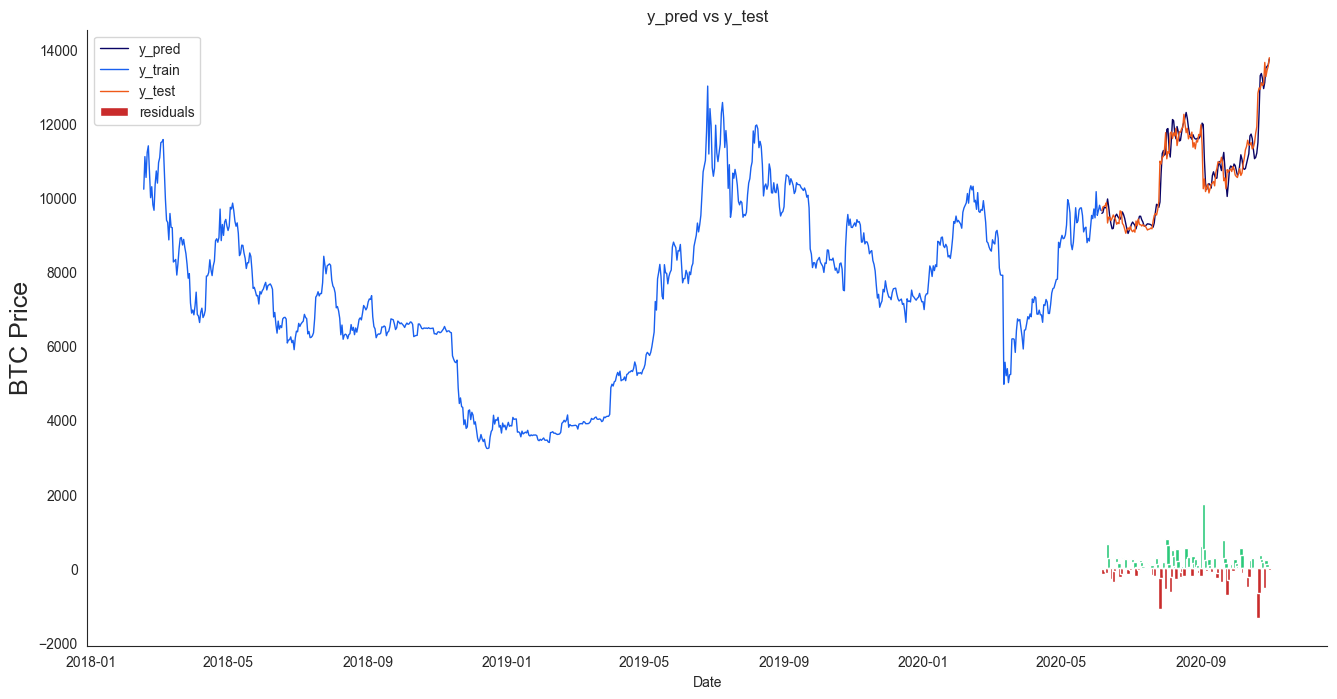

In [6]:

# The date from which on the date is displayed
display_start_date = "2018-01-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(train_df_ext['BTC Price'][:train_data_len + 1]).rename(columns={'BTC Price': 'y_train'})
valid = pd.DataFrame(train_df_ext['BTC Price'][train_data_len:]).rename(columns={'BTC Price': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel("BTC Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)

plt.legend()
plt.show()

